# Intro to DLC2Action

DLC2Action is a package for automatic behavior prediction. It offers implementation of SOTA models and keeps track of experiments.

To see how it works, we will experiment on a relatively small [publically available](https://github.com/ETHZ-INS/DLCAnalyzer/tree/master/data/OFT) dataset (Sturman, 2020). Run the code below to download the data.

In [5]:
!pip install gdown
!gdown https://drive.google.com/uc?id=1BhAAy_YYxWXYVSpCmYXIAOEV9waoMwcK
!apt-get install unzip
!unzip OFT.zip -d OFT

Downloading...
From: https://drive.google.com/uc?id=1BhAAy_YYxWXYVSpCmYXIAOEV9waoMwcK
To: /home/liza/DLC2Action_minimal/examples/OFT.zip
100%|█████████████████████████████████████████| 475M/475M [00:04<00:00, 111MB/s]
E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?
Archive:  OFT.zip
   creating: OFT/OFT/
  inflating: OFT/__MACOSX/._OFT      
  inflating: OFT/OFT/.DS_Store       
  inflating: OFT/__MACOSX/OFT/._.DS_Store  
   creating: OFT/OFT/Labels/
   creating: OFT/OFT/Output_DLC/
  inflating: OFT/OFT/Labels/23_02_A_190507135734.csv  
  inflating: OFT/OFT/Labels/12_01_A_190507144429.csv  
  inflating: OFT/OFT/Labels/53_04_A_190507135800.csv  
  inflating: OFT/OFT/Labels/43_03_A_190507151557.csv  
  inflating: OFT/OFT/Labels/57_04_A_190507150030.csv  
  inflating: OFT/OFT/Labels/25_02_A_190507142904.csv  
  inflating: OFT/OFT/Labels/AllLabDataOFT_final.csv  


... installation

for now:
```
git clone https://github.com/AlexEMG/DLC2Action
cd DLC2Action
conda create --name DLC2Action python=3.9
conda activate DLC2Action
python -m pip install .
```

In [6]:
from dlc2action.project import Project
import os

# CURRENT_PATH = os.getcwd()
# DATA_PATH = os.path.join(CURRENT_PATH, "OFT", "OFT", "Output_DLC")
# LABELS_PATH = os.path.join(CURRENT_PATH, "OFT", "OFT", "Labels")
# PROJECTS_PATH = os.path.join(CURRENT_PATH, "DLC2Action")

DATA_PATH = "/home/liza/OFT/Output_DLC"
LABELS_PATH = "/home/liza/OFT/Labels"
PROJECTS_PATH = "/home/liza/DLC2Action_tmp"

High-level methods in DLC2Action are almost exclusively accessed through the `dlc2action.project.Project` class. A project instance should loosely correspond to a specific goal (e.g. generating automatic annotations for dataset A with input format X). You can use it to optimize hyperparameters, run experiments, analyze results and generate new data.

**Best practices**
- When you need to do something with a different data type or unrelated files, it's better to create a new project to keep the experiment history easy to understand.
- Each project is associated with a folder on your computer that contains all settings, meta files and experiment outputs. Those folders are created in the folder at `projects_path`. It's generally a good idea to choose one and stick to it throughout projects.

### Creating a project

Let's begin!

We will create a project called `"oft"`, with `"dlc_track"` input and `"csv"` annotation format. 

You can run `Project.print_data_types()` and `Project.print_annotation_types()` to find out more about other options.

In [7]:
# Project.remove_project("oft", projects_path=PROJECTS_PATH)
project = Project(
    "oft",
    data_path=DATA_PATH,
    annotation_path=LABELS_PATH,
    projects_path=PROJECTS_PATH,
    data_type="dlc_track",
    annotation_type="csv",
)

Projects have a generalized `help` function.

In [8]:
project.help()

AVAILABLE HELP FUNCTIONS:
- Try running `project.help(keyword)` with the following keywords:
    - model: to get more information on available models,
    - features: to get more information on available feature extraction modes,
    - partition_method: to get more information on available train/test/val partitioning methods,
    - metrics: to see a list of available metric functions.
    - data: to see help for expected data structure
- To start working with this project, first run `project.list_blanks()` to check which parameters need to be filled in.
- After a model and metrics are set, run `project.list_basic_parameters()` to see a list of the most important parameters that you might want to modify
- If you want to dig deeper, get the full dictionary with project._read_parameters() (it is a `ruamel.yaml.comments.CommentedMap` instance).




In [9]:
Project.print_data_types()

DATA TYPES:
dlc_tracklet:

    DLC tracklet data

    Assumes the following file structure:
    ```
    data_path
    ├── video1DLC1000.pickle
    ├── video2DLC400.pickle
    ├── video1_features.pt
    └── video2_features.pt
    ```
    Here `data_suffix` is `{'DLC1000.pickle', 'DLC400.pickle'}` and `feature_suffix` (optional) is `'_features.pt'`.

    The feature files should to be dictionaries where keys are clip IDs (e.g. animal names) and values are
    feature values (arrays of shape `(#frames, #features)`). If the arrays are shaped as `(#features, #frames)`,
    set `transpose_features` to `True`.

    The files can be saved with `numpy.save()` (with `.npy` extension), `torch.save()` (with `.pt` extension) or
    with `pickle.dump()` (with `.pickle` or `.pkl` extension).
    
dlc_track:

    DLC track data

    Assumes the following file structure:
    ```
    data_path
    ├── video1DLC1000.pickle
    ├── video2DLC400.pickle
    ├── video1_features.pt
    └── video2_features.pt


Let's start by checking if our files are organized correctly.

In [10]:
project.help("data")

DATA:
Video data: dlc_track

    DLC track data

    Assumes the following file structure:
    ```
    data_path
    ├── video1DLC1000.pickle
    ├── video2DLC400.pickle
    ├── video1_features.pt
    └── video2_features.pt
    ```
    Here `data_suffix` is `{'DLC1000.pickle', 'DLC400.pickle'}` and `feature_suffix` (optional) is `'_features.pt'`.

    The feature files should to be dictionaries where keys are clip IDs (e.g. animal names) and values are
    feature values (arrays of shape `(#frames, #features)`). If the arrays are shaped as `(#features, #frames)`,
    set `transpose_features` to `True`.

    The files can be saved with `numpy.save()` (with `.npy` extension), `torch.save()` (with `.pt` extension) or
    with `pickle.dump()` (with `.pickle` or `.pkl` extension).
    
Annotation data: csv

    CSV type annotation data

    Assumes that files are saved as .csv tables with at least the following columns:
    - from / start : start of action,
    - to / end : end of action,
 

## Setting parameters

After the data structure is sorted out, it's time to configure the parameter settings. 

Every project keeps fixed settings written in configuration files in the project folder. When you want to change something, you have two options: modifying the configuration files so that this new value becomes the default (with `project.set_main_parameters` or `project.update_parameters`) or passing a `parameters_update` argument to your function so that the settings only change for this run.

We will start with setting the defaults.

As we saw in the help message, the first step is checking which essential parameters are missing with `project.list_blanks()`

In [11]:
project.list_blanks()

Before running experiments, please update all the blanks.
To do that, you can run this.
--------------------------------------------------------
project.update_parameters(
    {
        "data": {
            "data_suffix": ..., # set; the data files should have the format of {video_id}{data_suffix}, e.g. video1_suffix.pickle, where video1 is the video is and _suffix.pickle is the suffix
            "canvas_shape": ..., # list; the size of the canvas where the pose was defined
            "annotation_suffix": ..., # str | set, optional the suffix or the set of suffices such that the annotation files are named {video_id}{annotation_suffix}, e.g, video1_suffix.pickle where video1 is the video id and _suffix.pickle is the suffix
        },
        "general": {
            "exclusive": ..., # bool; if true, single-label classification is used; otherwise multi-label
        },
    }
)
--------------------------------------------------------
Replace ... with relevant values.


We can copy this code, fill in the information and run it.

In [12]:
project.update_parameters(
    {
        "data": {
            "data_suffix": "DeepCut_resnet50_Blockcourse1May9shuffle1_1030000.csv", # set; the data files should have the format of {video_id}{data_suffix}, e.g. video1_suffix.pickle, where video1 is the video is and _suffix.pickle is the suffix
            "canvas_shape": [928, 576], # list; the size of the canvas where the pose was defined
            "annotation_suffix": ".csv", # str | set, optional the suffix or the set of suffices such that the annotation files are named {video_id}{annotation_suffix}, e.g, video1_suffix.pickle where video1 is the video id and _suffix.pickle is the suffix
        },
        "general": {
            "exclusive": True, # bool; if true, single-label classification is used; otherwise multi-label
        },
    }
)

Now we're all set and can start training models. However, we can take an extra step and check out what other parameters are available.

Note that this function is only showing us the parameters for the metric functions and the model that are selected as default at the moment. If you want to see what parameters there are for other models and metrics, try setting them first with `project.set_main_parameters()` or with `project.update_parameters()`.

In [13]:
project.list_basic_parameters()

BASIC PARAMETERS:
Here is a list of current parameters.
You can copy this code, change the parameters you want to set and run it to update the project config.
--------------------------------------------------------
project.update_parameters(
    {
        "general": {
            "model_name": "c2f_tcn", # str; model name (run project.help("model") for more info)
            "metric_functions": {'f1', 'precision', 'recall'}, # set; set of metric names (run project.help("metrics") for more info)
            "ignored_clips": None, # list; a list of string clip ids (agent names) to be ignored
            "len_segment": 512, # int; the length of segments (in frames) to cut the videos into
            "overlap": 0.75, # int; the overlap (in frames) between neighboring segments
            "interactive": False, # bool; if true, annotations are assigned and features are computed for pairs of clips (animals)
        },
        "data": {
            "data_suffix": "DeepCut_resnet50_Blockcourse

We can copy this into a code cell to make it easier to read.

In [14]:
project.update_parameters(
    {
        "general": {
            "model_name": "c2f_tcn", # str; model name (run project.help("model") for more info)
            "metric_functions": {'precision', 'recall', 'f1'}, # set; set of metric names (run project.help("metrics") for more info)
            "ignored_clips": None, # list; a list of string clip ids (agent names) to be ignored
            "len_segment": 512, # int; the length of segments (in frames) to cut the videos into
            "overlap": 0.75, # int; the overlap (in frames) between neighboring segments
            "interactive": False, # bool; if true, annotations are assigned and features are computed for pairs of clips (animals)
        },
        "data": {
            "data_suffix": "DeepCut_resnet50_Blockcourse1May9shuffle1_1030000.csv", # set; the data files should have the format of {video_id}{data_suffix}, e.g. video1_suffix.pickle, where video1 is the video is and _suffix.pickle is the suffix
            "feature_suffix": None, # str; the feature files should be stored in the data folder and named {video_id}{feature_suffix}
            "annotation_suffix": ".csv", # str | set, optional the suffix or the set of suffices such that the annotation files are named {video_id}{annotation_suffix}, e.g, video1_suffix.pickle where video1 is the video id and _suffix.pickle is the suffix
            "canvas_shape": [928, 576], # list; the size of the canvas where the pose was defined
            "ignored_bodyparts": None, # set; the set of string names of bodyparts to ignore
            "likelihood_threshold": 0, # float; coordinates with lower likelihood values will be ignored
            "behaviors": None, # set; the behaviors to predict (if null, if will be inferred from the data; !!PLEASE SET IT MANUALLY if different files can have different behavior sets!!)
            "filter_annotated": True, # bool; discard long unannotated intervals during training
            "filter_background": True, # bool; only label frames as background if a behavior is annotated somewhere close
            "visibility_min_score": 0, # float; the minimum visibility score for visibility filtering
            "visibility_min_frac": 0, # float; the minimum fraction of visible frames for visibility filtering
        },
        "training": {
            "lr": 0.001, # float; learning rate
            "device": "auto", # str; device
            "num_epochs": 50, # int; number of epochs
            "to_ram": False, # bool; transfer the dataset to RAM for training (preferred if the dataset fits in working memory)
            "batch_size": 64, # int; batch size
            "normalize": True, # bool; if true, normalization statistics will be computed on the training set and applied to all data
            "temporal_subsampling_size": 0.85, # float; this fraction of frames in each segment is randomly sampled at training time
            "parallel": False, # bool; if true, the model will be trained on all gpus visible in the system (use os.environ[“CUDA_VISIBLE_DEVICES”] =“{indices}” to exclude gpus in this mode)
            "val_frac": 0.2, # float; fraction of dataset to use as validation
            "test_frac": 0, # float; fraction of dataset to use as test
            "partition_method": "random", # str; the train/test/val partitioning method (for more info run project.help("partition_method"))
        },
        "losses": {
            "ms_tcn": {
                "focal": True, # bool; if True, focal loss will be used
                "gamma": 2, # float; the gamma parameter of focal loss
                "alpha": 0.001, # float; the weight of consistency loss
            },
        },
        "metrics": {
            "f1": {
                "average": "macro", # ['macro', 'micro', 'none']; averaging method for classes
                "ignored_classes": None, # set; a set of class ids to ignore in calculation
                "threshold_value": 0.5, # float; the probability threshold for positive samples
            },
            "recall": {
                "average": "macro", # ['macro', 'micro', 'none']; averaging method for classes
                "ignored_classes": None, # set; a set of class ids to ignore in calculation
                "threshold_value": 0.5, # float; the probability threshold for positive samples
            },
            "precision": {
                "average": "macro", # ['macro', 'micro', 'none']; averaging method for classes
                "ignored_classes": None, # set; a set of class ids to ignore in calculation
                "threshold_value": 0.5, # float; the probability threshold for positive samples
            },
        },
        "model": {
            "num_f_maps": 128, # int; number of maps
            "feature_dim": None, # int; if not null, intermediate features are generated with this dimension and then passed to a 2-layer MLP for classification (useful for SSL)
        },
        "features": {
            "keys": None, # set; a list of names of the features to extract (a subset of available keys; run project.help("features") for more info)
            "averaging_window": 1, # int; if >1, features are averaged with a moving window of this size (in frames)
            "distance_pairs": None, # list; a list of bodypart name tuples (e.g. `[("tail", "nose")]`) to compute distances for when `"intra_distance"` is in `keys` (by default all distances are computed)
            "angle_pairs": None, # list; a list of bodypart name tuples (e.g. `[("ear1", "nose", "ear2")]`) for the angle between `"ear1"--"nose"` and `"nose"--"ear2"` lines) to compute angle cosines for when `"angles"` is in `keys` (by default no angles are computed)
            "zone_vertices": None, # dict; a dictionary of bodypart name tuples of any length >= 3 that define zones for `"zone_bools"`and `"zone_distances"` features; keys should be zone names and values should be tuples that define the polygons (e.g. `{"main_area": ("x_min", "x_max", "y_max", "y_min"))}`)
            "zone_bools": None, # list; a list of zone and bodypart name tuples to compute binary identifiers for (1 if an animal is within the polygon or 0 if it's outside) (e.g. `[("main_area", "nose")]`); the zones should be defined in the `zone_vertices` parameter; this is only computed if `"zone_bools"` is in `keys`
            "zone_distances": None, # list; a list of zone and bodypart name tuples to compute distances for (distance from the bodypart to the closest of the boundaries) (e.g. `[("main_area", "nose")]`); the zones should be defined in the `zone_vertices` parameter; this is only computed if `"zone_distances"` is in `keys`
            "area_vertices": None, # list; a list of bodypart name tuples of any length >= 3 (e.g. `[("ear1", "nose", "ear2", "spine1")]`) that define polygons to compute areas for when `"areas"` is in `keys` (by default no areas are computed)
        },
        "augmentations": {
            "augmentations": {'add_noise'}, # set; a set of augmentations that can be applied to your data without losing information (choose any number from 'rotate', 'real_lens', 'add_noise', 'shift', 'zoom', 'mirror', 'switch', e.g. {'add_noise'. 'mirror'})
            "rotation_limits": [-1.57, 1.57], # list; list of rotation angle limits in radians ([low, high])
            "mirror_dim": {0}, # set; set of dimensions that can be mirrored (0 for x, 1 for y, 2 for z)
            "noise_std": 0.003, # float; standard deviation of noise
            "zoom_limits": [0.5, 1.5], # list; list of float zoom limits ([low, high])
            "masking_probability": 0.1, # float; the probability of masking a joint
        },
    },
)

Let's see what the options are for metrics and models.

In [15]:
project.help("model")
project.help("metrics")

MODELS:
asformer:

    An implementation of ASFormer
    
mlp:

    A Multi-Layer Perceptron
    
c2f_tcn:

    An implementation of C2F-TCN

    Requires the `"general/len_segment"` parameter to be at least 512
    
edtcn:

    An implementation of EDTCN (Endoder-Decoder TCN)
    
transformer:

    A modification of Transformer-Encoder with additional max-pooling and upsampling

    Set `num_pool` to 0 to get a standart transformer-encoder.
    


METRICS:
accuracy:

    Accuracy
    
precision:

    Precision
    
f1:

    F1 score
    
recall:

    Recall
    
count:

    Fraction of samples labeled by the model as a class
    
segmental_precision:

    Segmental precision (not advised for training)
    
segmental_recall:

    Segmental recall (not advised for training)
    
segmental_f1:

    Segmental F1 score (not advised for training)
    
edit_distance:

    Edit distance (not advised for training)

    Normalized by the length of the sequences
    
f_beta:

    F-beta score
  

Which models and metrics do you want to try out?

You can choose any metrics but the code will run much faster if you avoid those marked "not advisable for training". We can compute those later with a trained model.

In [16]:
MODEL_NAME1 = "c2f_tcn"
MODEL_NAME2 = "transformer"
METRICS = ["f1", "precision"]

We will configure the metrics in the default parameters, as well as a smaller number of epochs. The model will be updated in each experiment independently, since we want to try out more than one.

In [17]:
project.update_parameters(
    {
        "general": {"metric_functions": METRICS},
        "training": {"num_epochs": 15}
    }
)

All done! Now we're ready to run experiments. 

## Hyperparameter search

There are many hyperparameters in model training, like the number of layers in a model or loss coefficients. The default settings for those parameters should generate reasonable results on most datasets but in order to get the most out of our data we can run a hyperparameter search.

Searches in `DLC2Action` use the `optuna` auto-ML package to sample the hyperpameter space efficiently and save time on trials that go badly from the beginning. 

There are two methods for running a search: `project.run_hyperparameter_search()` and `project.run_default_hyperparameter_search()`. As you might have guessed from the names, the second method will just load the default set of parameters for a given model while the first allows you to optimize whatever you want. For the vast majority of cases `project.run_default_hyperparameter_search()` should be enough, so that is what we will use in thi tutorial.

In [18]:
for model in [MODEL_NAME1, MODEL_NAME2]:
    project.run_default_hyperparameter_search(
        f"{model}_search",
        model_name=model,
        metric=METRICS[0],
        num_epochs=5,
        n_trials=10,
        prune=True,
        best_n=3 # we will compare trials based on the average of three best epochs to account for noise
    )


[I 2022-11-17 02:05:31,423] A new study created in memory with name: no-name-80513dce-d4cb-4027-a282-3d6ecfda34d1


SEARCH c2f_tcn_search
Computing input features...


100%|██████████| 20/20 [00:11<00:00,  1.69it/s]


Computing annotation arrays...


100%|██████████| 20/20 [00:00<00:00, 382.78it/s]


Filtering 93.33% of samples
Number of samples:
    validation:
      {-100: 4036, 3: 27, 1: 33, 2: 0, 4: 0, 0: 0}
    training:
      {-100: 16094, 1: 175, 3: 70, 4: 45, 2: 0, 0: 0}
    test:
      {1: 0, 2: 0, 3: 0, 4: 0, 0: 0}
Computing normalization statistics...


100%|██████████| 16/16 [00:00<00:00, 332.60it/s]

Initializing class weights:
    160000000.0, 0.091, 160000000.0, 0.229, 0.356
Behavior indices:
    0: other
    1: Grooming
    2: StartEnd
    3: Supported
    4: Unsupported


[epoch 1]: loss 1.6609, f1 0.131
validation: loss 1.5846, f1 0.124
[epoch 2]: loss 1.5614, f1 0.180
validation: loss 1.5838, f1 0.124
[epoch 3]: loss 1.4667, f1 0.205
validation: loss 1.5836, f1 0.124
[epoch 4]: loss 1.3847, f1 0.250
validation: loss 1.5841, f1 0.126
[epoch 5]: loss 1.2507, f1 0.316
validation: loss 1.5839, f1 0.203
[epoch 6]: loss 1.1333, f1 0.319
validation: loss 1.5829, f1 0.098
[epoch 7]: loss 0.9896, f1 0.355
validation: loss 1.5779, f1 0.160
[epoch 8]: loss 0.8769, f1 0.391
validation: loss 1.5676, f1 0.221
[epoch 9]: loss 0.7491, f1 0.442
validation: loss 1.5570, f1 0.217


[I 2022-11-17 02:05:48,937] Trial 0 finished with value: 0.21382138629754385 and parameters: {'losses/ms_tcn/alpha': 0.0004073904199604741, 'losses/ms_tcn/focal': False, 'training/temporal_subsampling_size': 0.8324508457055846, 'model/num_f_maps': 55, 'general/len_segment': 1024}. Best is trial 0 with value: 0.21382138629754385.


[epoch 10]: loss 0.6536, f1 0.425
validation: loss 1.5498, f1 0.201
Computing input features...


100%|██████████| 20/20 [00:08<00:00,  2.23it/s]


Computing annotation arrays...


100%|██████████| 20/20 [00:00<00:00, 308.74it/s]


Filtering 95.17% of samples
Number of samples:
    validation:
      {-100: 2500, 3: 27, 1: 33, 2: 0, 4: 0, 0: 0}
    training:
      {-100: 11998, 1: 175, 3: 70, 4: 45, 2: 0, 0: 0}
    test:
      {1: 0, 2: 0, 3: 0, 4: 0, 0: 0}
Computing normalization statistics...


100%|██████████| 24/24 [00:00<00:00, 471.90it/s]


Initializing class weights:
    240000000.0, 0.137, 240000000.0, 0.343, 0.533
Behavior indices:
    0: other
    1: Grooming
    2: StartEnd
    3: Supported
    4: Unsupported
[epoch 1]: loss 1.6227, f1 0.133
validation: loss 1.6144, f1 0.000
[epoch 2]: loss 1.4795, f1 0.252
validation: loss 1.6169, f1 0.000
[epoch 3]: loss 1.2537, f1 0.357
validation: loss 1.6193, f1 0.000
[epoch 4]: loss 0.9855, f1 0.409
validation: loss 1.6224, f1 0.000
[epoch 5]: loss 0.7393, f1 0.491
validation: loss 1.6220, f1 0.119
[epoch 6]: loss 0.6109, f1 0.511
validation: loss 1.6291, f1 0.000
[epoch 7]: loss 0.4179, f1 0.522
validation: loss 1.6418, f1 0.000
[epoch 8]: loss 0.3545, f1 0.551
validation: loss 1.6603, f1 0.000
[epoch 9]: loss 0.2797, f1 0.535
validation: loss 1.6837, f1 0.000
[epoch 10]: loss 0.1977, f1 0.570
validation: loss 1.7040, f1 0.000


[I 2022-11-17 02:06:00,385] Trial 1 finished with value: 0.03971630831559499 and parameters: {'losses/ms_tcn/alpha': 0.0002996848694821987, 'losses/ms_tcn/focal': False, 'training/temporal_subsampling_size': 0.8992204012740979, 'model/num_f_maps': 105, 'general/len_segment': 512}. Best is trial 0 with value: 0.21382138629754385.


Number of samples:
    validation:
      {-100: 2500, 3: 27, 1: 33, 2: 0, 4: 0, 0: 0}
    training:
      {-100: 11998, 1: 175, 3: 70, 4: 45, 2: 0, 0: 0}
    test:
      {1: 0, 2: 0, 3: 0, 4: 0, 0: 0}
Computing normalization statistics...


100%|██████████| 24/24 [00:00<00:00, 555.75it/s]


Initializing class weights:
    240000000.0, 0.137, 240000000.0, 0.343, 0.533
Behavior indices:
    0: other
    1: Grooming
    2: StartEnd
    3: Supported
    4: Unsupported
[epoch 1]: loss 0.2746, f1 0.048
validation: loss 0.2474, f1 0.000
[epoch 2]: loss 0.2491, f1 0.073
validation: loss 0.2461, f1 0.000
[epoch 3]: loss 0.2319, f1 0.083
validation: loss 0.2451, f1 0.000
[epoch 4]: loss 0.2173, f1 0.155
validation: loss 0.2444, f1 0.000
[epoch 5]: loss 0.1963, f1 0.212
validation: loss 0.2434, f1 0.000
[epoch 6]: loss 0.1706, f1 0.289
validation: loss 0.2425, f1 0.000
[epoch 7]: loss 0.1478, f1 0.347
validation: loss 0.2415, f1 0.000
[epoch 8]: loss 0.1262, f1 0.388
validation: loss 0.2404, f1 0.000
[epoch 9]: loss 0.1112, f1 0.435
validation: loss 0.2389, f1 0.000
[epoch 10]: loss 0.0943, f1 0.466
validation: loss 0.2373, f1 0.000


[I 2022-11-17 02:06:02,416] Trial 2 finished with value: 0.0 and parameters: {'losses/ms_tcn/alpha': 0.0006109278231204091, 'losses/ms_tcn/focal': True, 'training/temporal_subsampling_size': 0.9712610632452269, 'model/num_f_maps': 33, 'general/len_segment': 512}. Best is trial 0 with value: 0.21382138629754385.


Number of samples:
    validation:
      {-100: 4036, 3: 27, 1: 33, 2: 0, 4: 0, 0: 0}
    training:
      {-100: 16094, 1: 175, 3: 70, 4: 45, 2: 0, 0: 0}
    test:
      {1: 0, 2: 0, 3: 0, 4: 0, 0: 0}
Computing normalization statistics...


100%|██████████| 16/16 [00:00<00:00, 414.12it/s]

Initializing class weights:
    160000000.0, 0.091, 160000000.0, 0.229, 0.356
Behavior indices:
    0: other
    1: Grooming
    2: StartEnd
    3: Supported
    4: Unsupported


[epoch 1]: loss 0.1747, f1 0.089
validation: loss 0.1585, f1 0.000
[epoch 2]: loss 0.1629, f1 0.280
validation: loss 0.1579, f1 0.000
[epoch 3]: loss 0.1350, f1 0.401
validation: loss 0.1570, f1 0.000
[epoch 4]: loss 0.1059, f1 0.408
validation: loss 0.1560, f1 0.000
[epoch 5]: loss 0.0799, f1 0.435
validation: loss 0.1553, f1 0.080
[epoch 6]: loss 0.0589, f1 0.437
validation: loss 0.1551, f1 0.064
[epoch 7]: loss 0.0424, f1 0.507
validation: loss 0.1556, f1 0.050
[epoch 8]: loss 0.0270, f1 0.520
validation: loss 0.1561, f1 0.050
[epoch 9]: loss 0.0205, f1 0.562
validation: loss 0.1572, f1 0.050


[I 2022-11-17 02:06:04,874] Trial 3 finished with value: 0.06454544514417648 and parameters: {'losses/ms_tcn/alpha': 1.6333702155587746e-05, 'losses/ms_tcn/focal': True, 'training/temporal_subsampling_size': 0.8071009524543757, 'model/num_f_maps': 74, 'general/len_segment': 1024}. Best is trial 0 with value: 0.21382138629754385.


[epoch 10]: loss 0.0222, f1 0.561
validation: loss 0.1589, f1 0.050
Initializing class weights:
    160000000.0, 0.091, 160000000.0, 0.229, 0.356
Behavior indices:
    0: other
    1: Grooming
    2: StartEnd
    3: Supported
    4: Unsupported
[epoch 1]: loss 1.6774, f1 0.102
validation: loss 1.6514, f1 0.000
[epoch 2]: loss 1.5799, f1 0.264
validation: loss 1.6452, f1 0.000
[epoch 3]: loss 1.4717, f1 0.346
validation: loss 1.6373, f1 0.000
[epoch 4]: loss 1.3551, f1 0.437
validation: loss 1.6285, f1 0.000
[epoch 5]: loss 1.2286, f1 0.434
validation: loss 1.6200, f1 0.028
[epoch 6]: loss 1.0882, f1 0.451
validation: loss 1.6116, f1 0.089
[epoch 7]: loss 0.9281, f1 0.455
validation: loss 1.6035, f1 0.102
[epoch 8]: loss 0.7864, f1 0.512
validation: loss 1.5968, f1 0.145
[epoch 9]: loss 0.6014, f1 0.556
validation: loss 1.5879, f1 0.132
[epoch 10]: loss 0.5238, f1 0.552
validation: loss 1.5790, f1 0.175


[I 2022-11-17 02:06:06,779] Trial 4 finished with value: 0.15070205430189768 and parameters: {'losses/ms_tcn/alpha': 0.0005439086139427061, 'losses/ms_tcn/focal': False, 'training/temporal_subsampling_size': 0.8420471314526801, 'model/num_f_maps': 55, 'general/len_segment': 1024}. Best is trial 0 with value: 0.21382138629754385.


best parameters: {'losses/ms_tcn/alpha': 0.0004073904199604741, 'losses/ms_tcn/focal': False, 'training/temporal_subsampling_size': 0.8324508457055846, 'model/num_f_maps': 55, 'general/len_segment': 1024}


SEARCH transformer_search


[I 2022-11-17 02:06:09,483] A new study created in memory with name: no-name-5a7b33ac-816e-4ead-840c-f30cc75a3f22


Computing input features...


100%|██████████| 20/20 [00:08<00:00,  2.33it/s]


Computing annotation arrays...


100%|██████████| 20/20 [00:00<00:00, 618.98it/s]


Filtering 98.29% of samples
Number of samples:
    validation:
      {-100: 708, 3: 27, 1: 33, 2: 0, 4: 0, 0: 0}
    training:
      {-100: 4190, 1: 175, 3: 70, 4: 45, 2: 0, 0: 0}
    test:
      {1: 0, 2: 0, 3: 0, 4: 0, 0: 0}
Computing normalization statistics...


100%|██████████| 35/35 [00:00<00:00, 758.43it/s]

Initializing class weights:
    350000000.0, 0.2, 350000000.0, 0.5, 0.778
Behavior indices:
    0: other
    1: Grooming
    2: StartEnd
    3: Supported
    4: Unsupported


[epoch 1]: loss 0.0501, f1 0.157
validation: loss 0.2701, f1 0.122
[epoch 2]: loss 0.0333, f1 0.348
validation: loss 0.2695, f1 0.148
[epoch 3]: loss 0.0238, f1 0.421
validation: loss 0.2692, f1 0.137
[epoch 4]: loss 0.0171, f1 0.479
validation: loss 0.2689, f1 0.097
[epoch 5]: loss 0.0130, f1 0.481
validation: loss 0.2684, f1 0.103
[epoch 6]: loss 0.0101, f1 0.510
validation: loss 0.2679, f1 0.120
[epoch 7]: loss 0.0066, f1 0.580
validation: loss 0.2668, f1 0.127
[epoch 8]: loss 0.0045, f1 0.591
validation: loss 0.2658, f1 0.178
[epoch 9]: loss 0.0031, f1 0.597
validation: loss 0.2650, f1 0.172


[I 2022-11-17 02:06:24,105] Trial 0 finished with value: 0.17541193465391794 and parameters: {'losses/ms_tcn/alpha': 0.005872445259593748, 'losses/ms_tcn/focal': False, 'training/temporal_subsampling_size': 0.7666260209734416, 'model/N': 7, 'model/heads': 4, 'model/num_pool': 2, 'model/add_batchnorm': True, 'general/len_segment': 128}. Best is trial 0 with value: 0.17541193465391794.


[epoch 10]: loss 0.0026, f1 0.586
validation: loss 0.2640, f1 0.176
Initializing class weights:
    350000000.0, 0.2, 350000000.0, 0.5, 0.778
Behavior indices:
    0: other
    1: Grooming
    2: StartEnd
    3: Supported
    4: Unsupported
[epoch 1]: loss 0.0457, f1 0.146
validation: loss 0.1595, f1 0.233
[epoch 2]: loss 0.0434, f1 0.260
validation: loss 0.1271, f1 0.300
[epoch 3]: loss 0.0407, f1 0.255
validation: loss 0.1224, f1 0.359
[epoch 4]: loss 0.0359, f1 0.228
validation: loss 0.1161, f1 0.346
[epoch 5]: loss 0.0325, f1 0.225
validation: loss 0.1057, f1 0.293
[epoch 6]: loss 0.0297, f1 0.169
validation: loss 0.1246, f1 0.189
[epoch 7]: loss 0.0272, f1 0.268
validation: loss 0.2005, f1 0.184
[epoch 8]: loss 0.0247, f1 0.269
validation: loss 0.2969, f1 0.194
[epoch 9]: loss 0.0220, f1 0.324
validation: loss 0.3587, f1 0.132


[I 2022-11-17 02:06:26,186] Trial 1 finished with value: 0.33484355608622235 and parameters: {'losses/ms_tcn/alpha': 7.319650302741545e-05, 'losses/ms_tcn/focal': False, 'training/temporal_subsampling_size': 0.7626898923000842, 'model/N': 7, 'model/heads': 2, 'model/num_pool': 3, 'model/add_batchnorm': False, 'general/len_segment': 128}. Best is trial 1 with value: 0.33484355608622235.


[epoch 10]: loss 0.0184, f1 0.384
validation: loss 0.2836, f1 0.177
Initializing class weights:
    350000000.0, 0.2, 350000000.0, 0.5, 0.778


[I 2022-11-17 02:06:26,725] Trial 2 pruned. 


Behavior indices:
    0: other
    1: Grooming
    2: StartEnd
    3: Supported
    4: Unsupported
Computing input features...


100%|██████████| 20/20 [00:08<00:00,  2.22it/s]


Computing annotation arrays...


100%|██████████| 20/20 [00:00<00:00, 311.45it/s]


Filtering 98.91% of samples
Number of samples:
    validation:
      {3: 27, -100: 452, 1: 33, 2: 0, 4: 0, 0: 0}
    training:
      {-100: 2526, 1: 175, 3: 70, 4: 45, 2: 0, 0: 0}
    test:
      {1: 0, 2: 0, 3: 0, 4: 0, 0: 0}
Computing normalization statistics...


100%|██████████| 44/44 [00:00<00:00, 800.69it/s]


Initializing class weights:
    440000000.0, 0.251, 440000000.0, 0.629, 0.978


[I 2022-11-17 02:06:36,704] Trial 3 pruned. 


Behavior indices:
    0: other
    1: Grooming
    2: StartEnd
    3: Supported
    4: Unsupported
Number of samples:
    validation:
      {-100: 708, 3: 27, 1: 33, 2: 0, 4: 0, 0: 0}
    training:
      {-100: 4190, 1: 175, 3: 70, 4: 45, 2: 0, 0: 0}
    test:
      {1: 0, 2: 0, 3: 0, 4: 0, 0: 0}
Computing normalization statistics...


100%|██████████| 35/35 [00:00<00:00, 642.68it/s]


Initializing class weights:
    350000000.0, 0.2, 350000000.0, 0.5, 0.778


[I 2022-11-17 02:06:37,725] Trial 4 pruned. 
[W 2022-11-17 02:06:37,727] Param general/len_segment unique value length is less than 2.
[W 2022-11-17 02:06:37,728] Param losses/ms_tcn/focal unique value length is less than 2.
[W 2022-11-17 02:06:37,729] Param model/N unique value length is less than 2.
[W 2022-11-17 02:06:37,730] Param general/len_segment unique value length is less than 2.
[W 2022-11-17 02:06:37,731] Param general/len_segment unique value length is less than 2.
[W 2022-11-17 02:06:37,733] Param general/len_segment unique value length is less than 2.
[W 2022-11-17 02:06:37,734] Param general/len_segment unique value length is less than 2.
[W 2022-11-17 02:06:37,735] Param general/len_segment unique value length is less than 2.


Behavior indices:
    0: other
    1: Grooming
    2: StartEnd
    3: Supported
    4: Unsupported


[W 2022-11-17 02:06:37,737] Param losses/ms_tcn/focal unique value length is less than 2.
[W 2022-11-17 02:06:37,739] Param model/N unique value length is less than 2.
[W 2022-11-17 02:06:37,740] Param general/len_segment unique value length is less than 2.
[W 2022-11-17 02:06:37,742] Param losses/ms_tcn/focal unique value length is less than 2.
[W 2022-11-17 02:06:37,743] Param model/N unique value length is less than 2.
[W 2022-11-17 02:06:37,743] Param losses/ms_tcn/focal unique value length is less than 2.
[W 2022-11-17 02:06:37,744] Param losses/ms_tcn/focal unique value length is less than 2.
[W 2022-11-17 02:06:37,745] Param losses/ms_tcn/focal unique value length is less than 2.
[W 2022-11-17 02:06:37,746] Param losses/ms_tcn/focal unique value length is less than 2.
[W 2022-11-17 02:06:37,747] Param general/len_segment unique value length is less than 2.
[W 2022-11-17 02:06:37,748] Param model/N unique value length is less than 2.
[W 2022-11-17 02:06:37,749] Param losses/ms_tc

best parameters: {'losses/ms_tcn/alpha': 7.319650302741545e-05, 'losses/ms_tcn/focal': False, 'training/temporal_subsampling_size': 0.7626898923000842, 'model/N': 7, 'model/heads': 2, 'model/num_pool': 3, 'model/add_batchnorm': False, 'general/len_segment': 128}




Those searches will optimize the hyperparameters to maximize the first metric in our list. Note how some trials stop before reaching 10 epochs. That is happening because we have set `prune=True` to interrupt experiments when they are unlikely to beat the best score.

Generally, it is better to set both the number of trials and the number of epochs much higher (30-50 and around 150, respectively, is usually a good choice). We are setting them low here to save time but keep in mind that it does mean that the parameters those searches find are probably not actually optimal.

The searches have created a bunch of datasets that we are not going to use again so it's a good idea to clean up the memory at this point.

In [19]:
project.remove_saved_features()

Removing datasets...


100%|██████████| 4/4 [00:00<00:00, 160.79it/s]

`DLC2Action` needs pre-computed features to run an experiment. It keeps track of features that are stored on your system and does not re-compute them if they have already been created in other experiments with the same data parameters. They can take up a lot of space, however, so it's good practice to remove them sometimes. 

Do not be afraid to run `project.remove_saved_features()`, you never lose any information when you do. The features will just be computed again if you need them. In addition, if you are running low on space, it might be more convenient to pass `remove_saved_features=True` to project methods to remove the features as soon as they are not needed anymore.

Another function that helps clean up the memory is `project.remove_extra_checkpoints()`. DLC2Action saves a model checkpoint every 5 epochs by default (you can change this interval at `"training/model_save_interval"`). Running this method will remove all the checkpoints except for the last one in each episode.

When the searches are done, we can check out the results.

In [20]:
for model in [MODEL_NAME1, MODEL_NAME2]:
    _ = project.list_best_parameters(f"{model}_search")

SEARCH RESULTS c2f_tcn_search
losses/ms_tcn/alpha: 0.0004073904199604741
losses/ms_tcn/focal: False
training/temporal_subsampling_size: 0.8324508457055846
model/num_f_maps: 55
general/len_segment: 1024


SEARCH RESULTS transformer_search
losses/ms_tcn/alpha: 7.319650302741545e-05
losses/ms_tcn/focal: False
training/temporal_subsampling_size: 0.7626898923000842
model/N: 7
model/heads: 2
model/num_pool: 3
model/add_batchnorm: False
general/len_segment: 128




The searches can be used to update the default parameters with `project.update_parameters(load_search=search_name)` but in this case it's more convenient to load them in the relevant episodes.

## Training models

Now we can train models with the best hyperparameters.

In [21]:
for model in [MODEL_NAME1, MODEL_NAME2]:
    project.run_episode(
        f"{model}_best",
        load_search=f"{model}_search", # loading the search
        force=True, # when force=True, if an episode with this name already exists it will be overwritten -> use with caution!
        parameters_update={
            "general": {"model_name": model} # note that you do need to set the model explicitly, it is not loaded with the search
        },
        n_seeds=3 # we will repeat the experiment 3 times (same parameters, different random seed) to get an estimation for how stable our results are
)

TRAINING c2f_tcn_best::0
Computing input features...


100%|██████████| 20/20 [00:10<00:00,  1.87it/s]


Computing annotation arrays...


100%|██████████| 20/20 [00:00<00:00, 563.74it/s]


Filtering 96.00% of samples
Number of samples:
    validation:
      {-100: 8059, 3: 66, 1: 67, 2: 0, 4: 0, 0: 0}
    training:
      {-100: 40364, 1: 342, 3: 154, 4: 100, 2: 0, 0: 0}
    test:
      {1: 0, 2: 0, 3: 0, 4: 0, 0: 0}
Computing normalization statistics...


100%|██████████| 40/40 [00:00<00:00, 476.27it/s]

Initializing class weights:
    400000000.0, 0.117, 400000000.0, 0.26, 0.4
Behavior indices:
    0: other
    1: Grooming
    2: StartEnd
    3: Supported
    4: Unsupported


[epoch 1]: loss 1.6129, f1 0.167, precision 0.217
validation: loss 1.5889, f1 0.000, precision 0.000
[epoch 2]: loss 1.4992, f1 0.294, precision 0.325
validation: loss 1.5856, f1 0.000, precision 0.000
[epoch 3]: loss 1.3780, f1 0.408, precision 0.419
validation: loss 1.5822, f1 0.000, precision 0.000
[epoch 4]: loss 1.2555, f1 0.433, precision 0.441
validation: loss 1.5784, f1 0.000, precision 0.000
[epoch 5]: loss 1.1041, f1 0.463, precision 0.462
validation: loss 1.5733, f1 0.061, precision 0.253
[epoch 6]: loss 0.9307, f1 0.486, precision 0.492
validation: loss 1.5659, f1 0.117, precision 0.153
[epoch 7]: loss 0.7666, f1 0.485, precision 0.484
validation: loss 1.5587, f1 0.161, precision 0.185
[epoch 8]: loss 0.6027, f1 0.507, precision 0.504
validation: loss 1.5552, f1 0.155, precision 0.167
[epoch 9]: loss 0.4483, f1 0.528, precision 0.517
validation: loss 1.5520, f1 0.155, precision 0.167
[epoch 10]: loss 0.4009, f1 0.556, precision 0.555
validation: loss 1.5477, f1 0.163, preci

100%|██████████| 40/40 [00:00<00:00, 561.73it/s]


Initializing class weights:
    400000000.0, 0.117, 400000000.0, 0.26, 0.4
Behavior indices:
    0: other
    1: Grooming
    2: StartEnd
    3: Supported
    4: Unsupported
[epoch 1]: loss 1.6298, f1 0.146, precision 0.226
validation: loss 1.5457, f1 0.133, precision 0.099
[epoch 2]: loss 1.4936, f1 0.244, precision 0.318
validation: loss 1.5406, f1 0.133, precision 0.099
[epoch 3]: loss 1.3321, f1 0.356, precision 0.389
validation: loss 1.5397, f1 0.133, precision 0.099
[epoch 4]: loss 1.1729, f1 0.387, precision 0.407
validation: loss 1.5414, f1 0.133, precision 0.099
[epoch 5]: loss 0.9802, f1 0.446, precision 0.444
validation: loss 1.5436, f1 0.133, precision 0.099
[epoch 6]: loss 0.7897, f1 0.512, precision 0.499
validation: loss 1.5465, f1 0.133, precision 0.099
[epoch 7]: loss 0.6243, f1 0.538, precision 0.525
validation: loss 1.5487, f1 0.164, precision 0.303
[epoch 8]: loss 0.5104, f1 0.542, precision 0.532
validation: loss 1.5489, f1 0.272, precision 0.326
[epoch 9]: loss 0.

100%|██████████| 20/20 [00:09<00:00,  2.21it/s]


Computing annotation arrays...


100%|██████████| 20/20 [00:00<00:00, 303.26it/s]


Filtering 98.21% of samples
Number of samples:
    validation:
      {-100: 3216, 3: 108, 1: 132, 2: 0, 4: 0, 0: 0}
    training:
      {-100: 17307, 1: 670, 3: 275, 4: 180, 2: 0, 0: 0}
    test:
      {1: 0, 2: 0, 3: 0, 4: 0, 0: 0}
Computing normalization statistics...


100%|██████████| 144/144 [00:00<00:00, 644.60it/s]
/home/liza/DLC2Action_minimal/dlc2action/project/meta.py:665: FutureWarning:

Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.



Initializing class weights:
    1440000000.0, 0.215, 1440000000.0, 0.524, 0.8
Behavior indices:
    0: other
    1: Grooming
    2: StartEnd
    3: Supported
    4: Unsupported
[epoch 1]: loss 0.0483, f1 0.133, precision 0.237
validation: loss 0.0496, f1 0.145, precision 0.210
[epoch 2]: loss 0.0395, f1 0.263, precision 0.277
validation: loss 0.0523, f1 0.170, precision 0.177
[epoch 3]: loss 0.0321, f1 0.239, precision 0.244
validation: loss 0.0581, f1 0.190, precision 0.210
[epoch 4]: loss 0.0281, f1 0.217, precision 0.280
validation: loss 0.0348, f1 0.114, precision 0.098
[epoch 5]: loss 0.0315, f1 0.234, precision 0.291
validation: loss 0.0358, f1 0.253, precision 0.303
[epoch 6]: loss 0.0355, f1 0.185, precision 0.274
validation: loss 0.0389, f1 0.173, precision 0.175
[epoch 7]: loss 0.0442, f1 0.193, precision 0.273
validation: loss 0.0579, f1 0.141, precision 0.110
[epoch 8]: loss 0.0306, f1 0.180, precision 0.355
validation: loss 0.0700, f1 0.092, precision 0.130
[epoch 9]: loss

100%|██████████| 144/144 [00:00<00:00, 855.36it/s]


Initializing class weights:
    1440000000.0, 0.215, 1440000000.0, 0.524, 0.8
Behavior indices:
    0: other
    1: Grooming
    2: StartEnd
    3: Supported
    4: Unsupported
[epoch 1]: loss 0.0459, f1 0.184, precision 0.326
validation: loss 0.0725, f1 0.142, precision 0.110
[epoch 2]: loss 0.0359, f1 0.231, precision 0.364
validation: loss 0.1640, f1 0.142, precision 0.154
[epoch 3]: loss 0.0391, f1 0.267, precision 0.295
validation: loss 0.1820, f1 0.108, precision 0.252
[epoch 4]: loss 0.0279, f1 0.187, precision 0.249
validation: loss 0.0974, f1 0.170, precision 0.332
[epoch 5]: loss 0.0348, f1 0.274, precision 0.385
validation: loss 0.0905, f1 0.142, precision 0.110
[epoch 6]: loss 0.0276, f1 0.278, precision 0.341
validation: loss 0.0851, f1 0.145, precision 0.114
[epoch 7]: loss 0.0263, f1 0.352, precision 0.348
validation: loss 0.0667, f1 0.147, precision 0.317
[epoch 8]: loss 0.0246, f1 0.328, precision 0.352
validation: loss 0.0691, f1 0.139, precision 0.226
[epoch 9]: loss

## Evaluation

Now that we've trained our best models, we can analyze the results. Note that most statistics are aggregated over the 3 runs (random seeds) automatically. 

In [22]:
best_episodes = [f"{model}_best" for model in [MODEL_NAME1, MODEL_NAME2]]

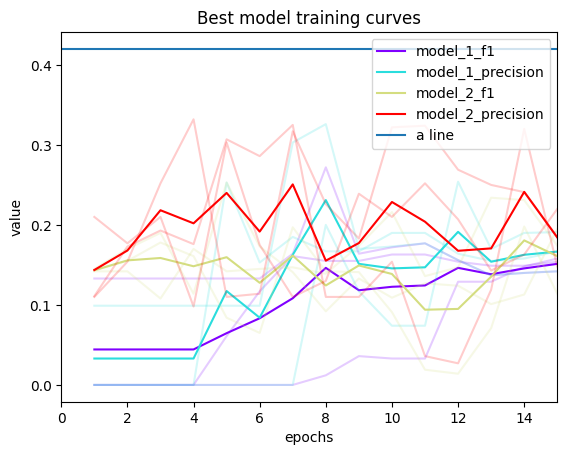

In [23]:
project.plot_episodes(
    best_episodes,
    metrics=METRICS, 
    episode_labels=["model_1", "model_2"], 
    add_hlines=[(0.42, "a line")], # we'll add a random horizontal line here but you can use this parameter to mark important thresholds
    title="Best model training curves"
)

The bold lines here are the means over the three runs of each episode and the transparent lines are the individual runs.

We can also check out more metrics now.

In [24]:
for episode in best_episodes:
    project.evaluate(
        [episode],
        parameters_update={
            "general": {"metric_functions": ["segmental_f1", "mAP", "f1"]},
            "metrics": {
                "f1": {"average": "none"}
            }
        }
    )

EVALUATION c2f_tcn_best
episode c2f_tcn_best::0
Number of samples:
    validation:
      {-100: 8059, 3: 66, 1: 67, 2: 0, 4: 0, 0: 0}
    training:
      {-100: 40364, 1: 342, 3: 154, 4: 100, 2: 0, 0: 0}
    test:
      {1: 0, 2: 0, 3: 0, 4: 0, 0: 0}
Setting loaded normalization statistics...
Initializing class weights:
    400000000.0, 0.117, 400000000.0, 0.26, 0.4
Behavior indices:
    0: other
    1: Grooming
    2: StartEnd
    3: Supported
    4: Unsupported


100%|██████████| 1/1 [00:00<00:00, 27.36it/s]


f1_0 0.000, f1_1 0.439, f1_2 0.000, f1_3 0.330, f1_4 0.000, mAP 0.000, segmental_f1 0.000


AGGREGATED:
f1_0 0.000, f1_1 0.439, f1_2 0.000, f1_3 0.330, f1_4 0.000, mAP 0.000, segmental_f1 0.000
Inference time: 0:00:00


EVALUATION transformer_best
episode transformer_best::0
Number of samples:
    validation:
      {-100: 3216, 3: 108, 1: 132, 2: 0, 4: 0, 0: 0}
    training:
      {-100: 17307, 1: 670, 3: 275, 4: 180, 2: 0, 0: 0}
    test:
      {1: 0, 2: 0, 3: 0, 4: 0, 0: 0}
Setting loaded normalization statistics...
Initializing class weights:
    1440000000.0, 0.215, 1440000000.0, 0.524, 0.8
Behavior indices:
    0: other
    1: Grooming
    2: StartEnd
    3: Supported
    4: Unsupported


100%|██████████| 1/1 [00:00<00:00, 20.86it/s]


f1_0 0.000, f1_1 0.587, f1_2 0.000, f1_3 0.389, f1_4 0.000, mAP 0.000, segmental_f1 0.000


AGGREGATED:
f1_0 0.000, f1_1 0.587, f1_2 0.000, f1_3 0.389, f1_4 0.000, mAP 0.000, segmental_f1 0.000
Inference time: 0:00:00




There are several ways to summarize the results.

In [25]:
project.get_results_table(best_episodes)

RESULTS:
         c2f_tcn_best f1  c2f_tcn_best precision  transformer_best f1  \
average          0.15128                  0.1667             0.161027   

         transformer_best precision  
average                    0.184331  




,c2f_tcn_best f1,c2f_tcn_best precision,transformer_best f1,transformer_best precision
average,0.15128,0.1667,0.161027,0.184331


The `get_summary` method will only show the metrics computed during training while `get_results_table` also pulls up the results of evaluation.

In [26]:
for episode in best_episodes:
    _ = project.get_summary([episode])

SUMMARY ['c2f_tcn_best']
loss: mean 1.594, std 0.005
f1: mean 0.151, std 0.007
precision: mean 0.167, std 0.020


SUMMARY ['transformer_best']
loss: mean 0.071, std 0.013
f1: mean 0.161, std 0.034
precision: mean 0.184, std 0.029




## Using trained models

After your models are trained, there's a few ways you can use them.

If you're still not quite happy with the results, you can train the model for a few more epochs with `project.continue_episode()`.

In [27]:
project.continue_episode(f"{MODEL_NAME1}_best", num_epochs=20, n_seeds=3)

TRAINING c2f_tcn_best::0
Computing input features...


  0%|          | 0/20 [00:00<?, ?it/s]

You can also train another episode with different parameters that loads the weights of your model as an initialization. Note that it will use all three runs as starting points for its own three runs.

In [ ]:
project.run_episode(
    f"{MODEL_NAME1}_best_lr1e-5",
    load_episode=f"{MODEL_NAME1}_best",
    load_search=f"{MODEL_NAME1}_search",
    parameters_update={
        "general": {"model_name": MODEL_NAME1},
        "training": {"lr": 1e-5, "num_epochs": 5}
    },
    force=True,
)

TRAINING c2f_tcn_best_lr1e-5::0


/home/liza/DLC2Action_minimal/dlc2action/project/project.py:3692: UserWarning: The partitioning parameters in the loaded experiment ({'partition_method': 'file'}) are not equal to the current partitioning parameters ({'val_frac': 0.2, 'test_frac': 0, 'partition_method': 'random', 'only_load_annotated': True, 'len_segment': 1024, 'overlap': 0.75}). The current parameters are replaced.
  warnings.warn(


Number of samples:
    validation:
      {0: 10660, 1: 5414, 2: 1340, 3: 1816, 4: 500, 5: 2594, 6: 0, 7: 0}
    training:
      {0: 27747, 1: 16566, 2: 87393, 3: 10991, 4: 23594, 5: 45042, 6: 92, 7: 61104}
    test:
      {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0}
Computing normalization statistics...


100%|██████████| 415/415 [00:01<00:00, 258.09it/s]


Initializing class weights:
     0: 0.001, 0.001, 0.002, 0.001, 0.001, 0.001, 0.001, 0.001 1: 0.015, 0.025, 0.005, 0.038, 0.018, 0.009, 4.511, 0.007
Behavior indices:
    0: anogenital
    1: approach
    2: attack
    3: avoidance
    4: boxing
    5: lateralthreat
    6: pursuit
    7: submission
[epoch 1]: loss 0.0001, f1 0.595, precision 0.479
validation: loss 0.0006, f1 0.076, precision 0.044
[epoch 2]: loss 0.0001, f1 0.603, precision 0.485
validation: loss 0.0006, f1 0.076, precision 0.044
[epoch 3]: loss 0.0001, f1 0.608, precision 0.492
validation: loss 0.0005, f1 0.077, precision 0.044
[epoch 4]: loss 0.0001, f1 0.608, precision 0.490
validation: loss 0.0005, f1 0.077, precision 0.044
[epoch 5]: loss 0.0001, f1 0.618, precision 0.502
validation: loss 0.0005, f1 0.077, precision 0.044


TRAINING c2f_tcn_best_lr1e-5::1


/home/liza/DLC2Action_minimal/dlc2action/project/project.py:3692: UserWarning: The partitioning parameters in the loaded experiment ({'partition_method': 'file'}) are not equal to the current partitioning parameters ({'val_frac': 0.2, 'test_frac': 0, 'partition_method': 'random', 'only_load_annotated': True, 'len_segment': 1024, 'overlap': 0.75}). The current parameters are replaced.
  warnings.warn(


Initializing class weights:
     0: 0.001, 0.001, 0.002, 0.001, 0.001, 0.001, 0.001, 0.001 1: 0.015, 0.025, 0.005, 0.038, 0.018, 0.009, 4.511, 0.007
Behavior indices:
    0: anogenital
    1: approach
    2: attack
    3: avoidance
    4: boxing
    5: lateralthreat
    6: pursuit
    7: submission
[epoch 1]: loss 0.0000, f1 0.752, precision 0.643
validation: loss 0.0007, f1 0.093, precision 0.062
[epoch 2]: loss 0.0000, f1 0.771, precision 0.662
validation: loss 0.0007, f1 0.093, precision 0.062
[epoch 3]: loss 0.0000, f1 0.776, precision 0.669
validation: loss 0.0007, f1 0.094, precision 0.063
[epoch 4]: loss 0.0000, f1 0.781, precision 0.677
validation: loss 0.0007, f1 0.097, precision 0.065
[epoch 5]: loss 0.0000, f1 0.779, precision 0.675
validation: loss 0.0007, f1 0.098, precision 0.066


TRAINING c2f_tcn_best_lr1e-5::2


/home/liza/DLC2Action_minimal/dlc2action/project/project.py:3692: UserWarning: The partitioning parameters in the loaded experiment ({'partition_method': 'file'}) are not equal to the current partitioning parameters ({'val_frac': 0.2, 'test_frac': 0, 'partition_method': 'random', 'only_load_annotated': True, 'len_segment': 1024, 'overlap': 0.75}). The current parameters are replaced.
  warnings.warn(


Initializing class weights:
     0: 0.001, 0.001, 0.002, 0.001, 0.001, 0.001, 0.001, 0.001 1: 0.015, 0.025, 0.005, 0.038, 0.018, 0.009, 4.511, 0.007
Behavior indices:
    0: anogenital
    1: approach
    2: attack
    3: avoidance
    4: boxing
    5: lateralthreat
    6: pursuit
    7: submission
[epoch 1]: loss 0.0001, f1 0.680, precision 0.569
validation: loss 0.0007, f1 0.116, precision 0.077
[epoch 2]: loss 0.0001, f1 0.696, precision 0.588
validation: loss 0.0006, f1 0.116, precision 0.077
[epoch 3]: loss 0.0000, f1 0.706, precision 0.599
validation: loss 0.0006, f1 0.117, precision 0.081
[epoch 4]: loss 0.0000, f1 0.711, precision 0.606
validation: loss 0.0006, f1 0.119, precision 0.084
[epoch 5]: loss 0.0000, f1 0.717, precision 0.611
validation: loss 0.0006, f1 0.118, precision 0.084




You can also plot such episodes together as one line.

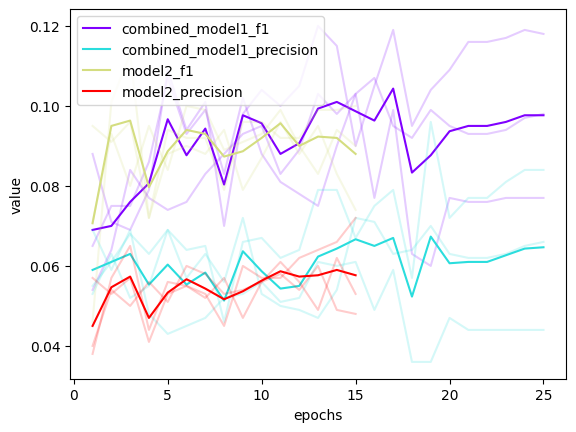

In [ ]:
project.plot_episodes(
    [[f"{MODEL_NAME1}_best", f"{MODEL_NAME1}_best_lr1e-5"], f"{MODEL_NAME2}_best"], 
    episode_labels=["combined_model1", "model2"],
    metrics=METRICS
)

All the episodes you have run are stored in the project memory and you can pull up the history with all the parameters.

In [ ]:
_ = project.list_episodes(
    display_parameters=["general/model_name", "meta/training_time", "meta/time", f"results/{METRICS[0]}"], # choose the parameters to display
    value_filter="training/lr::>1e-5" # filter the entries by any parameter or result
)

TRAINING EPISODES
                         general          meta                        results
                      model_name training_time                 time        f1
c2f_tcn_best::0          c2f_tcn       0:01:34  2022-11-16 23:42:05  0.077177
c2f_tcn_best::1          c2f_tcn       0:01:26  2022-11-16 23:42:27  0.095438
c2f_tcn_best::2          c2f_tcn       0:01:26  2022-11-16 23:42:49  0.109345
transformer_best::0  transformer       0:07:41  2022-11-16 22:47:39  0.073708
transformer_best::1  transformer       0:07:32  2022-11-16 22:55:50  0.100461
transformer_best::2  transformer       0:07:31  2022-11-16 23:03:24  0.089784




The same goes for hyperparameter searches and predictions. This function also returns a `pandas` table you can process yourself.

In [ ]:
searches = project.list_searches(print_results=False)
searches.head()

meta            \
                                   time objective   
c2f_tcn_search      2022-11-16 22:36:42        f1   
transformer_search  2022-11-16 22:41:33        f1   

                                                              results  \
                                                          best_params   
c2f_tcn_search      {'losses/ms_tcn/alpha': 0.00012063720101101104...   
transformer_search  {'losses/ms_tcn/alpha': 1.0610250513468929e-05...   

                                     data                              \
                   best_value data_prefix feature_suffix canvas_shape   
c2f_tcn_search       0.092646        None           None  [1290, 730]   
transformer_search   0.113672        None           None  [1290, 730]   

                                                                    ...  \
                   ignored_bodyparts likelihood_threshold centered  ...   
c2f_tcn_search                  None                    0    False  ...   
transformer_search              None                    0    False  ...   

                            f1                 precision                  \
                   tag_average threshold_value   average ignored_classes   
c2f_tcn_search           micro             0.5     macro            None   
transformer_search       micro             0.5     macro            None   

                                                           model              \
                   tag_average threshold_value         input_dim     N heads   
c2f_tcn_search           micro             0.5               NaN   NaN   NaN   
transformer_search       micro             0.5  dataset_features  10.0   4.0   

                             
                   num_pool  
c2f_tcn_search          NaN  
transformer_search      3.0  

[2 rows x 109 columns]

When you find that you are happy with the results, you can use the model to generate predictions for new data. 

Predictions here are probabilities of each behavior being seen in each frame while suggestions are suggested intervals generated from those probabilities.

Let's generate a prediction with one of our models and look at one of the resulting files. Note that you can use multiple models and average over their predictions.

In [ ]:
project.run_prediction(
    f"{MODEL_NAME1}_best_prediction",
    episode_names=[f"{MODEL_NAME1}_best_lr1e-5"],
    force=True
)

PREDICTION c2f_tcn_best_prediction
episode c2f_tcn_best_lr1e-5::0
Number of samples:
    validation:
      {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0}
    training:
      {0: 38407, 1: 21980, 2: 88733, 3: 12807, 4: 24094, 5: 47636, 6: 92, 7: 61104}
    test:
      {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0}
Setting loaded normalization statistics...
Initializing class weights:
     0: 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001 1: 0.014, 0.025, 0.006, 0.042, 0.022, 0.011, 5.859, 0.009
Behavior indices:
    0: anogenital
    1: approach
    2: attack
    3: avoidance
    4: boxing
    5: lateralthreat
    6: pursuit
    7: submission


100%|██████████| 9/9 [00:10<00:00,  1.18s/it]

In [ ]:
import pickle
import os


# picking a random file from the prediction folder
prediction_folder = project.prediction_path(f"{MODEL_NAME1}_best_prediction")
prediction_file = os.listdir(prediction_folder)[0]
prediction_file = os.path.join(prediction_folder, prediction_file)

with open(prediction_file, "rb") as f: # open the file
    prediction = pickle.load(f)

for key, value in prediction.items(): # explore the contents
    if key not in ["max_frames", "min_frames", "video_tag", "behaviors"]:
        print(f'{key}: {value.shape}')
    
behaviors_order = prediction["behaviors"]

start = 50
end = 70
action = "attack"

index = behaviors_order.index(action)

print(f'The mean probability of {action} between frames {start} and {end} is {prediction["1+2"][index, start: end].mean()}')

1+2: torch.Size([8, 18611])
The mean probability of attack between frames 50 and 70 is 0.7315972447395325


In [ ]:
project.remove_saved_features()
project.remove_extra_checkpoints()

Removing datasets...


100%|██████████| 7/7 [00:01<00:00,  4.47it/s]

## Working with custom data

If you want to work with your own data, first check `Project.print_data_types()` and `Project.print_annotation_types()` to check if we already have the format that you need.

If we don't, you can choose either of them to transform your data to but the easiest is probably `DeepLabCut` track or tracklet for the pose estimation data and our custom `"dlc"` format for annotation.

Let's talk about the latter in more detail.

It assumes every annotation file to be a pickled nested dictionary where first-level keys are individual names, second-level keys are behavior names and values are lists of intervals. Here is an example.
```
{
    "ind0": {
        "running": [[20, 30], [40, 50]]
    },
    "ind1": {
        "eating": [[10, 56]]
    }
}
```

Here `"ind0"` is running in frames 20 to 30 and 40 to 50 while `"ind1"` is eating in frames 10 to 56.

In case your dataset contains interactive actions, connect the individual names with a plus (e.g. `"ind0+ind1"`). At the moment, we can only support two scenarios: either all actions are interactive or all are individual. In case they are interactive, update the parameters with `project.update_parameters({"general": {"interactive": True}})` before running experiments.

As an exercise, let's generate a file in this format from one of the CSV files we've been working with.

In [ ]:
import os
import pandas as pd
import numpy as np
import pickle

filename = [x for x in os.listdir(DATA_PATH) if x.endswith(".csv")][0] # load a random .csv file
filepath = os.path.join(DATA_PATH, filename)

data = pd.read_csv(filepath)

In [ ]:
data.head()

,scorer,Ear_left_1_x,Ear_left_1_y,Ear_left_1_p,Ear_right_1_x,Ear_right_1_y,Ear_right_1_p,Nose_1_x,Nose_1_y,Nose_1_p,...,Low_prob_detections_0.5,Low_prob_detections_0.75,attack_prediction,lateralthreat_prediction,pursuit_prediction,anogenital_prediction,submission_prediction,boxing_prediction,approach_prediction,avoidance_prediction
0,0,570,529,0.999855,538,547,0.999982,572,547,0.951415,...,8,8,0,0,0,0,0,0,0,0
1,1,570,528,0.999820,538,547,0.999986,572,547,0.974408,...,8,8,0,0,0,0,0,0,0,0
2,2,570,527,0.999680,538,547,0.999987,571,548,0.986395,...,8,8,0,0,0,0,0,0,0,0
3,3,569,526,0.999499,538,547,0.999991,574,548,0.998246,...,8,8,0,0,0,0,0,0,0,0
4,4,567,518,0.999974,538,545,0.999979,586,545,0.999956,...,8,8,0,0,0,0,0,0,0,0


Behaviors here are interactive, the animal names are `"1"` and `"2"` and the annotations are encoded as binary arrays in the last columns. Let's use this to generate our dictionary.

In [ ]:
for filename in [x for x in os.listdir(DATA_PATH) if x.endswith(".csv")]:
    filepath = os.path.join(DATA_PATH, filename)
    data = pd.read_csv(filepath)
    dlc_dict = {"1+2": {}}
    behavior_columns = [column for column in data.columns if column.endswith("prediction")] # get relevant columns
    for column in behavior_columns:
        behavior = column.split("_")[0] # get the name of the behavior
        diff = np.diff(np.pad(data[column].values, (1, 1))) # find the starts and ends of positive intervals
        start_indices = np.where(diff == 1)[0]
        end_indices = np.where(diff == -1)[0]
        dlc_dict["1+2"][behavior] = []
        for start, end in zip(start_indices, end_indices):
            dlc_dict["1+2"][behavior].append([start, end]) # add intervals to the dictionary
    new_name = filepath.split(".")[0] + "_dlc.pickle" # the filenames need to start with the video name
    with open(new_name, "wb") as f: # save the annotation file
        pickle.dump(dlc_dict, f)

Let's check that we did everything right. We will create a new project with the new data type and run a small experiment.

In [ ]:
project = Project(
    "rat_simba_dlc",
    data_path=DATA_PATH,
    annotation_path=DATA_PATH,
    data_type="simba",
    annotation_type="dlc",
    projects_path=PROJECTS_PATH
)

In [ ]:
project.update_parameters(
    {
        "data": {
            "canvas_shape": [1290, 730], # list; [x, y] size of the canvas where the coordinates are defined
            "data_suffix": ".csv", # str; the data suffix (the data files should be named {video_id}{data_suffix}, e.g. video1_suffix.pickle, where video1 is the video is and _suffix.pickle is the suffix
            "annotation_suffix": "_dlc.pickle", # str | set, optional the suffix or the set of suffices such that the annotation files are named {video_id}{annotation_suffix}, e.g, video1_suffix.pickle where video1 is the video id and _suffix.pickle is the suffix
        },
        "general": {
            "exclusive": False, # bool; if true, single-label classification is used; otherwise multi-label
            "interactive": True,
            "model_name": "c2f_tcn",
            "len_segment": 512
        },
        "augmentations": {
            "augmentations": {"add_noise", "mirror", "rotate"}, # set; a set of augmentations that can be applied to your data without losing information (choose any number from 'rotate', 'real_lens', 'add_noise', 'shift', 'zoom', 'mirror', 'switch', e.g. {'add_noise'. 'mirror'})
        },
        "training": {"num_epochs": 5},
    }
)

In [ ]:
project.remove_saved_features()
project.run_episode("test", force=True)

Removing datasets...


TRAINING test
Computing input features...


100%|██████████| 12/12 [00:26<00:00,  2.21s/it]


Computing annotation arrays...


100%|██████████| 12/12 [00:00<00:00, 3215.46it/s]


Number of samples:
    validation:
      {0: 0, 1: 3217, 2: 21916, 3: 2216, 4: 3440, 5: 4773, 6: 0, 7: 18124}
    training:
      {0: 39896, 1: 19287, 2: 67706, 3: 10938, 4: 21034, 5: 44116, 6: 92, 7: 43455}
    test:
      {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0}
Computing normalization statistics...


100%|██████████| 971/971 [00:02<00:00, 364.87it/s]


Initializing class weights:
     0: 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002 1: 0.024, 0.05, 0.014, 0.089, 0.046, 0.022, 10.554, 0.022
Behavior indices:
    0: anogenital
    1: approach
    2: attack
    3: avoidance
    4: boxing
    5: lateralthreat
    6: pursuit
    7: submission
[epoch 1]: loss 0.0005, f1 0.252, precision 0.161, recall 0.867
validation: loss 0.0008, f1 0.331, precision 0.270, recall 0.496
[epoch 2]: loss 0.0004, f1 0.330, precision 0.227, recall 0.915
validation: loss 0.0009, f1 0.351, precision 0.281, recall 0.545
[epoch 3]: loss 0.0003, f1 0.380, precision 0.274, recall 0.921
validation: loss 0.0005, f1 0.419, precision 0.331, recall 0.628
[epoch 4]: loss 0.0003, f1 0.440, precision 0.331, recall 0.924
validation: loss 0.0005, f1 0.401, precision 0.314, recall 0.630
[epoch 5]: loss 0.0003, f1 0.441, precision 0.331, recall 0.943
validation: loss 0.0006, f1 0.434, precision 0.353, recall 0.611




## Annotation

You can also use `DLC2Action` to generate new annotation files. Install our interface following those instructions and try running it with any video you like.

... Installation

for now:
```
git clone https://github.com/amathislab/dlc2action_annotation
cd dlc2action_annotation
conda env create -f AnnotationGUI.yaml
```

To start, go to the `dlc2action_annotation` folder and run `python annotator.py`.